<a href="https://colab.research.google.com/github/ai-coodinator/DALL-E/blob/main/DALL_E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](http://colab.research.google.com/github/ai-coordinator/blob/DALL-E/DALL-E.ipynb)

#Reference
https://github.com/cedro3/others
# SetUP

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-880b9754-767d-1582-ed79-fc0878ad63e6)


In [ ]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html ftfy regex
!pip install DALL-E
!pip install ftfy
!git clone https://github.com/openai/CLIP.git
%cd /content/CLIP/

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 71kB 5.7MB/s 
  Created wheel for ftfy: filename=ftfy-5.9-cp37-none-any.whl size=46451 sha256=67963ffe86dc6a5aa2b38e4e130a7fc9a4b0e9bf612cc16b9cc47b3ae7c8fcbe
  Stored in directory: /root/.cache/pip/wheels/5e/2e/f0/b07196e8c929114998f0316894a61c752b63bfa3fdd50d2fc3
Successfully built ftfy
     |████████████████████████████████| 21.6MB 47.8MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 747kB 49.0MB/s 
     |████████████████████████████████| 1.9MB 53.5MB/s 
ERROR: blobfile 1.1.1 has requirement urllib3~=1.25, but you'll have urllib3 1.24.3 which is incompatible.
Cloning into 'CLIP'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 70 (delta 0), reused 1 (delta 0), pack-reused 64
Unpacking objects: 100% (70/70), done.
/content/CLIP


# Import Library & Define

In [ ]:
import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF
import PIL
import matplotlib.pyplot as plt
import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
import glob
from google.colab import output
InteractiveShell.ast_node_interactivity = "all"

# probably don't mess with this unless you're changing generator size
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape

def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  return display.Image(str(3)+'.png')

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

def get_all(img):
  img = np.transpose(img, (0,2,3,1))
  cards = np.zeros((img.shape[0], sideX+12, sideY+12, 3))
  for i in range(len(img)):
    cards[i] = card_padded(img[i])
  print(img.shape)
  cards = gallery(cards)
  imageio.imwrite(str(3) + '.png', np.array(cards))
  return display.Image(str(3)+'.png')

# Perceptor

In [ ]:
import clip
clip.available_models()

# Load the model
perceptor, preprocess = clip.load('ViT-B/32', jit=True)
perceptor = perceptor.eval()

['RN50', 'RN101', 'RN50x4', 'ViT-B/32']

100%|███████████████████████████████████████| 354M/354M [00:09<00:00, 37.6MiB/s]


# Generator

In [ ]:
import io
import os, sys
import requests
import PIL
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from dall_e import map_pixels, unmap_pixels, load_model

target_image_size = sideX

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)

model = load_model("https://cdn.openai.com/dall-e/decoder.pkl", 'cuda')

# Text input

In [ ]:
text_input = "A beautiful woman swimming in the blue sea" 
tau_value =1.2

# Latent coordinate

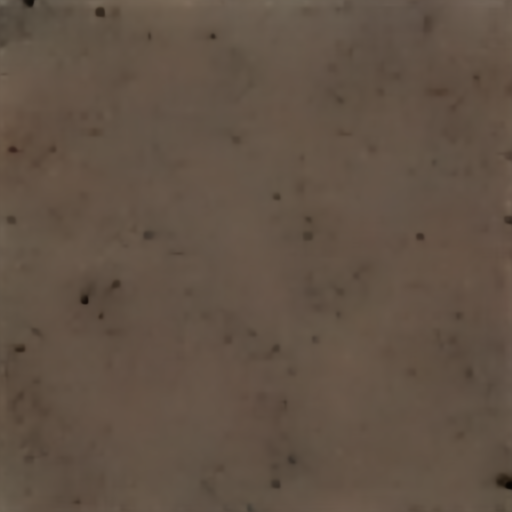

In [ ]:
class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()
        self.normu = torch.nn.Parameter(torch.randn(1, 8192, 64, 64).cuda())

    def forward(self):
      # normu = torch.nn.functional.gumbel_softmax(self.normu.view(1, 8192, -1), dim=-1).view(1, 8192, 64, 64)
      normu = torch.nn.functional.gumbel_softmax(self.normu.view(1, 8192, -1), dim=-1, tau=tau_value).view(1, 8192, 64, 64)
      return normu

lats = Pars().cuda()
mapper = [lats.normu]
optimizer = torch.optim.Adam([{'params': mapper, 'lr': .1}])
eps = 0
tx = clip.tokenize(text_input)
t = perceptor.encode_text(tx.cuda()).detach().clone()
nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

with torch.no_grad():
  mult = 1
  al = unmap_pixels(torch.sigmoid(model(lats()).cpu().float())).numpy()
  for allls in al:
    displ(allls[:3])
    print('\n')
  # print(torch.topk(lats().view(1, 8192, -1), k=3, dim=-1))

# Train

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


##########################################################  

[0, tensor([-1.8535], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 0


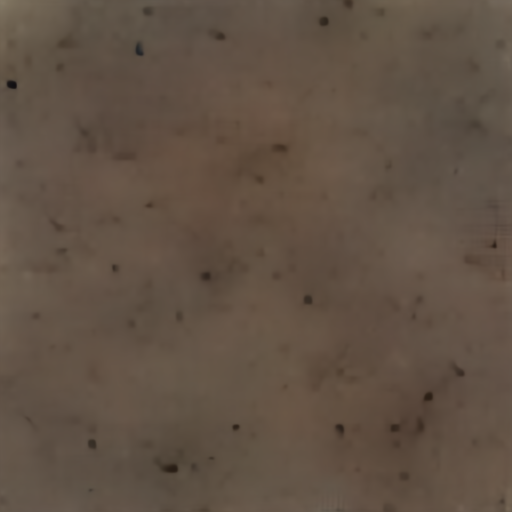



##########################################################  

[0, tensor([-3.8008], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 100


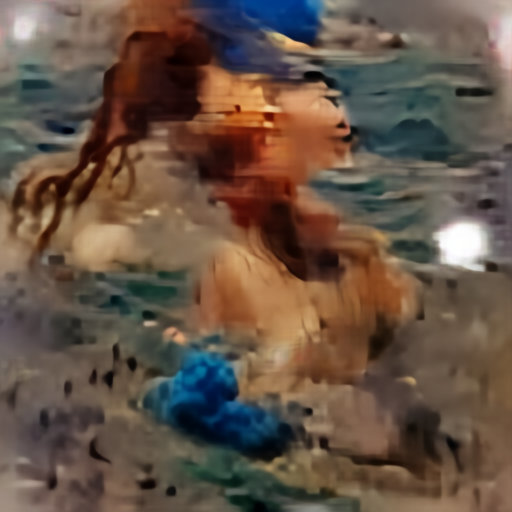



##########################################################  

[0, tensor([-4.0352], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 200


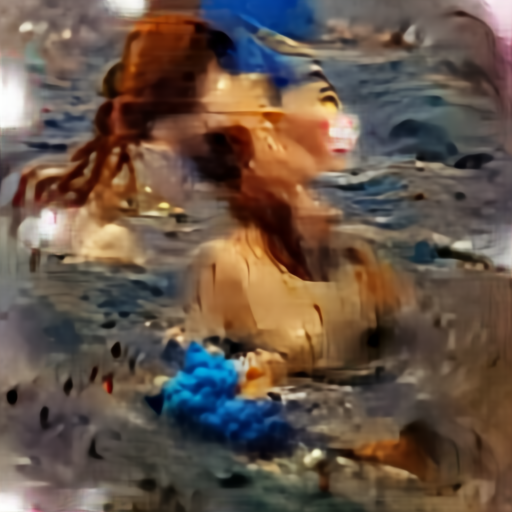



##########################################################  

[0, tensor([-3.9141], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 300


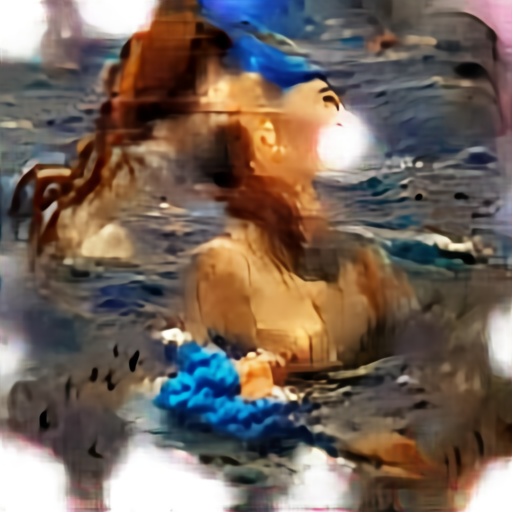



##########################################################  

[0, tensor([-4.0664], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 400


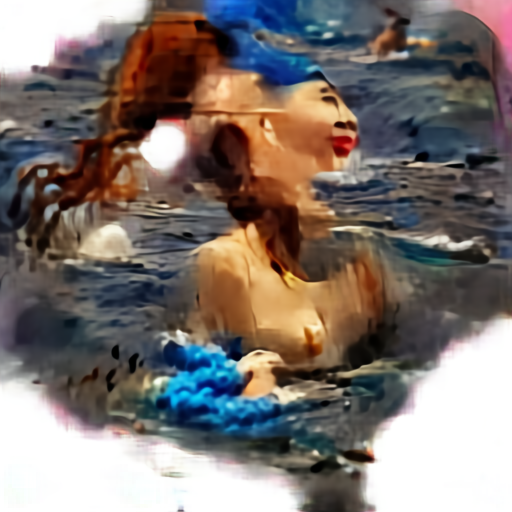



##########################################################  

[0, tensor([-4.0781], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 500


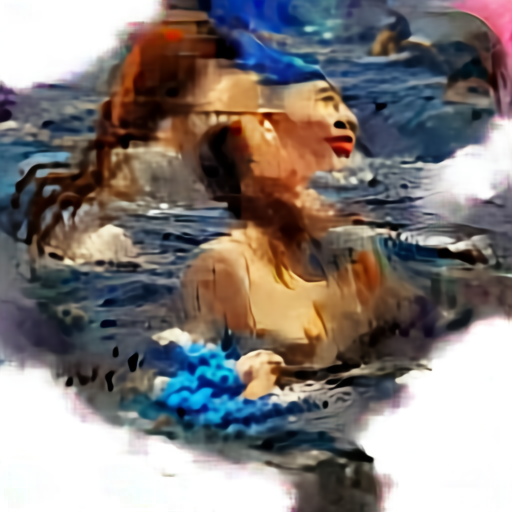



##########################################################  

[0, tensor([-4.0469], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 600


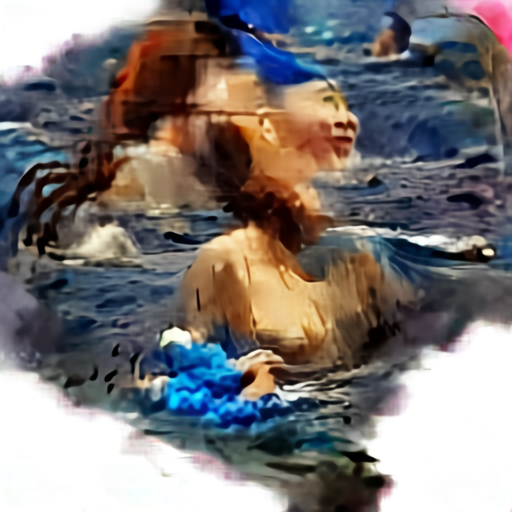



##########################################################  

[0, tensor([-4.2148], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 700


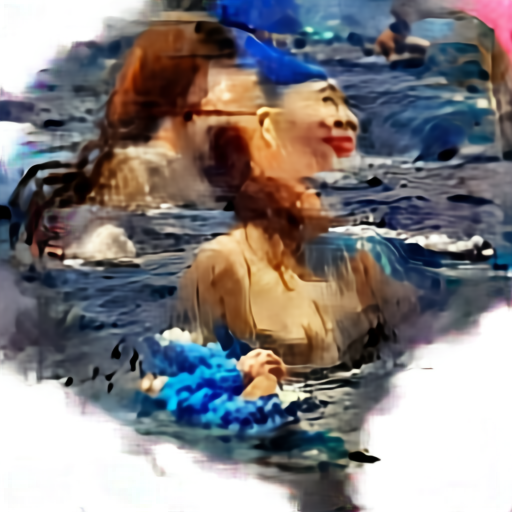



##########################################################  

[0, tensor([-4.3711], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 800


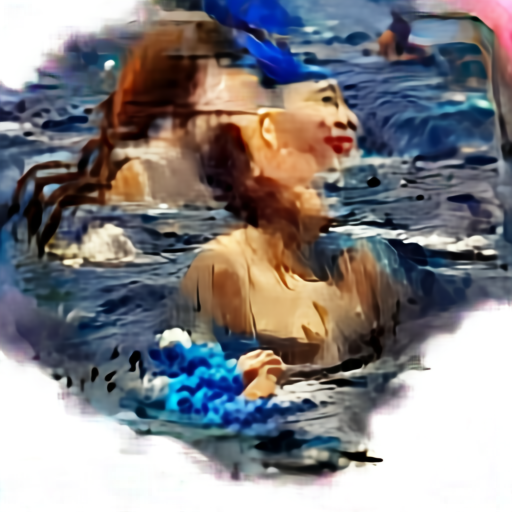



##########################################################  

[0, tensor([-4.4453], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 900


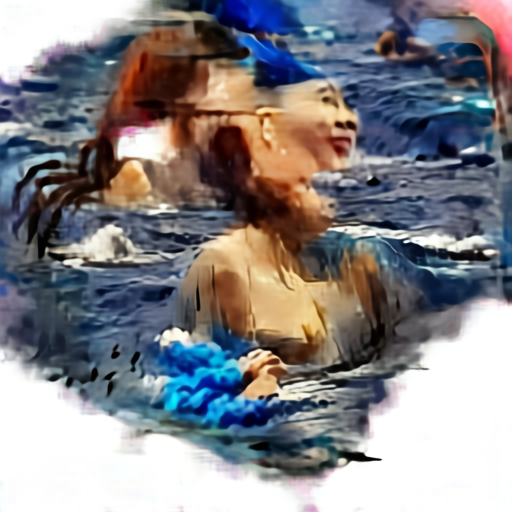



##########################################################  

[0, tensor([-4.4141], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)] 
 1000


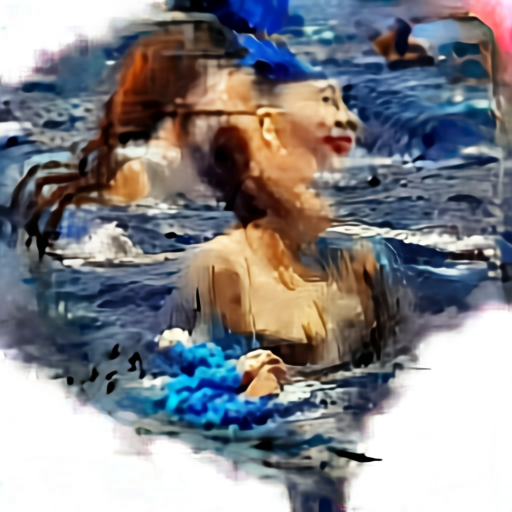

In [ ]:
def checkin(loss):
  print('''########################################################## ''',loss, '\n',itt)
  
  with torch.no_grad():
    al = unmap_pixels(torch.sigmoid(model(lats())[:, :3]).cpu().float()).numpy()
  for allls in al:
    displ(allls)
    display.display(display.Image(str(3)+'.png'))
    print('\n')
  # the people spoke and they love "ding"
  # output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')

def ascend_txt():
  out = unmap_pixels(torch.sigmoid(model(lats())[:, :3].float()))
  cutn = 64 # improves quality
  p_s = []
  for ch in range(cutn):
    size = int(sideX*torch.zeros(1,).normal_(mean=.8, std=.3).clip(.5, .98))
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(apper)
  into = torch.cat(p_s, 0)
  # into = torch.nn.functional.interpolate(out, (224,224), mode='nearest')
  into = nom(into)
  iii = perceptor.encode_image(into)
  llls = lats()
  lat_l = 0
  return [lat_l, 10*-torch.cosine_similarity(t, iii).view(-1, 1).T.mean(1)]

def train(i):
  loss1 = ascend_txt()
  loss = loss1[0] + loss1[1]
  loss = loss.mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
    
  if itt % 100 == 0:
    checkin(loss1)
    shutil.copy('./3.png', './images/%s.png'%str(int(itt/100)).zfill(6))

import shutil

if os.path.isdir('images'):
    shutil.rmtree('images')
os.makedirs('images', exist_ok=True)

itt = 0
for asatreat in range(1100):
  train(itt)
  itt+=1

# Make movie

In [ ]:
if os.path.exists('./output.mp4'):
   os.remove('./output.mp4')

!ffmpeg -r 2 -i images/%06d.png -vcodec libx264 -pix_fmt yuv420p output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib